In [54]:

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import get_scorer
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape
from keras.utils import plot_model
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adam, RMSprop
import math
from pandas import DataFrame
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import math
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
def bollinger_bands(series: pd.Series, length: int = 20, *, num_stds: tuple[float, ...] = (2, 0, -2), prefix: str = '') -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/74283044/
    rolling = series.rolling(length)
    bband0 = rolling.mean()
    bband_std = rolling.std(ddof=0)
    return pd.DataFrame({f'{prefix}{num_std}': (bband0 + (bband_std * num_std)) for num_std in num_stds})
def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr
def MACD(
        cls,
        ohlc: DataFrame,
        period_fast: int = 12,
        period_slow: int = 26,
        signal: int = 9,
        column: str = "Close",
        adjust: bool = True,
    ) -> DataFrame:
    """
    MACD, MACD Signal and MACD difference.
    The MACD Line oscillates above and below the zero line, which is also known as the centerline.
    These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross.
    Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA.
    This means upside momentum is increasing. Negative MACD values indicates that the 12-day EMA is below the 26-day EMA.
    Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.
    Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD Line.
    As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.
    A bullish crossover occurs when the MACD turns up and crosses above the signal line.
    A bearish crossover occurs when the MACD turns down and crosses below the signal line.
    """
    EMA_fast = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_fast, adjust=adjust).mean(),
        name="EMA_fast",
    )
    EMA_slow = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_slow, adjust=adjust).mean(),
        name="EMA_slow",
    )
    MACD = pd.Series(EMA_fast - EMA_slow, name="MACD")
    MACD_signal = pd.Series(
        MACD.ewm(ignore_na=False, span=signal, adjust=adjust).mean(), name="SIGNAL"
    )
    return pd.concat([MACD, MACD_signal], axis=1)

def stochastics(dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal
    When the %K crosses below %D, sell signal
    """
    df = dataframe.copy()
    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()
    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['k_fast'].ffill(inplace=True)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()
    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    return df
def plot_train_history(history, title):
  """
    Helper for neural nets
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()
def mean_absolute_percentage_error(y_true, y_pred):
    """
      Error calculator
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:

# Load Coca's data
df = pd.DataFrame(yf.Ticker("KO").history(start='2019-01-01', end='2023-09-30', interval='1d'))
# Add 10, 20, 50, 100 moving averages, both simple and exponential
for length in [10, 20, 50, 100]:
    df[f'ma_{length}'] = df['Close'].rolling(length).mean()
    df[f'ema_{length}'] = df['Close'].ewm(span = length, adjust = False ).mean()
df['rsi'] = RSI(df["Close"], 14)
# Add bollinger bands
df['upper_band']= bollinger_bands(df["Close"])['2']
df['mid_band']= bollinger_bands(df["Close"])['0']
df['lower_band']= bollinger_bands(df["Close"])['-2']
# Add OBV
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
# Add william r%
df['william'] = get_wr(df['High'], df['Low'], df['Close'], 14)
# Add MACD
df['macd'] = MACD(df, df)['MACD']
df['signal'] = MACD(df, df)['SIGNAL']
# Add stochastic
df = stochastics(df, 'Low', 'High', 'Close', 14, 3 )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 36, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 36, 64)            49408     
                                                                 
 dense_3 (Dense)             (None, 36, 64)            4160      
                                                                 
 dropout_2 (Dropout)         (None, 36, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

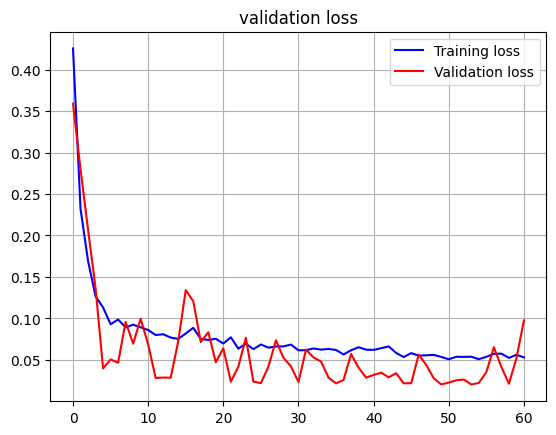

Evaluate model on test data
4/4 [==============================] - 0s 14ms/step
--------------------------------------------------------
test MAPE: 10.115452317187225 %
-------------------------------------------------------
Trend Catch Accuracy: 62.38532110091744 %


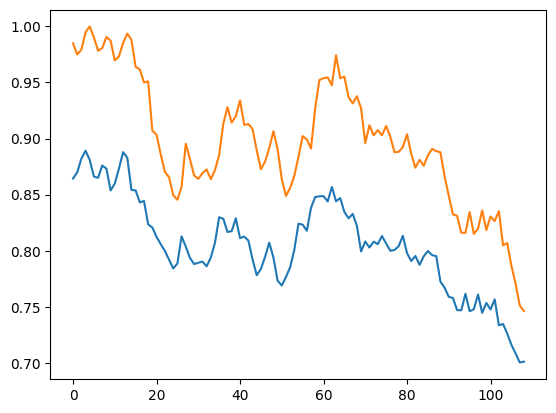

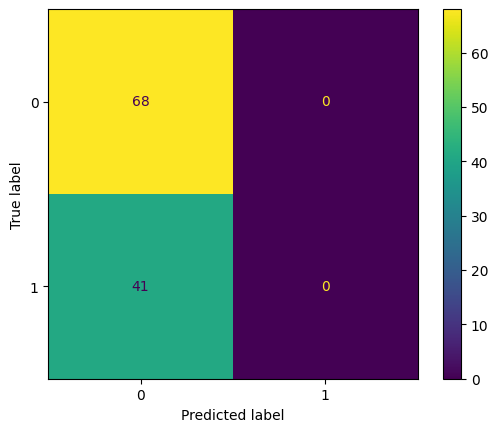

'Try me again B'

In [58]:

def run_nets(horizon, number_lags):
    # Length of the trainign dataset
    TRAIN_SPLIT = math.ceil(len(df.Close)*0.9*0.9)
    read_df = pd.DataFrame()
    read_df.index = pd.to_datetime(df.index)

    # Scale prices
    scaler = MinMaxScaler()
    scaler.fit(df['Close'].values[:TRAIN_SPLIT].reshape(-1, 1))
    read_df['Close'] = scaler.transform(df['Close'].values.reshape(-1, 1)).reshape(-1)

    # Add lags
    for period in range(horizon, number_lags+1):
      read_df[f'lag_{period}'] = read_df['Close'].shift(periods = period, axis = 0)

    # Add multy variate data
    multy_variate_Closing_Price = []
    for index in range(len(df)):
      if index > horizon-1:
        multy_variate_Closing_Price.append((read_df.Close.values[index-horizon:index]))

    # Add to dataframe
    read_df = read_df[horizon:]
    read_df['multy_close'] = multy_variate_Closing_Price
    read_df = read_df.drop(['Close'], axis=1)
    read_df = read_df.dropna()

    # Add indicators
    cols = ['ma_10', 'ema_10', 'ma_20', 'ema_20', 'ma_50', 'ema_50', 'ma_100',
          'ema_100', 'rsi', 'upper_band', 'mid_band', 'lower_band', 'obv',
          'william', 'macd', 'signal', 'k_fast', 'd_fast', 'k_slow', 'd_slow']
    indicators = df[cols]
    indicators = indicators.loc[indicators.index >= read_df.index[0]]
    scaler_indicators = MinMaxScaler()
    scaler_indicators.fit(indicators)
    read_df[indicators.columns] = scaler_indicators.transform(indicators)

    # Move target column to the beggining
    column_to_move = read_df.pop('multy_close')
    read_df.insert(0, 'multy_close', column_to_move)

    read_df = read_df.dropna()

    # Split data into train test validation
    TRAIN_SPLIT = math.ceil(len(read_df)*0.9*0.9)
    y_train = np.stack(read_df.iloc[:TRAIN_SPLIT, 0].values)
    x_train = np.expand_dims(read_df.iloc[:TRAIN_SPLIT, 1:].values, axis=2)
    y_val = np.stack(read_df.iloc[TRAIN_SPLIT:math.ceil(TRAIN_SPLIT/0.9), 0].values)
    x_val= np.expand_dims(read_df.iloc[TRAIN_SPLIT:math.ceil(TRAIN_SPLIT/0.9), 1:].values, axis=2)
    y_test = np.stack(read_df.iloc[math.ceil(TRAIN_SPLIT/0.9):, 0].values)
    x_test = np.expand_dims(read_df.iloc[math.ceil(TRAIN_SPLIT/0.9):, 1:].values, axis=2)

    # LSTM Architecture
    BATCH_SIZE = 32 # bacth size in batch-SGD/variants
    BUFFER_SIZE = 10000 # for shuffling the dataset
    train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()# defaule is repeated till number of time batch run
    #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
    val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128,
                                  return_sequences=True,
                                  input_shape=x_train.shape[-2:],
                                  activation='relu'
                                  ))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(horizon, activation='relu'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mae')
    # Train and evaluate
    STEPS_PER_EPOCH = 10
    EPOCHS = 100
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model.summary()
    multy_step_history = model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=10, callbacks=[callback])
    # Plot validation loss
    plot_train_history(multy_step_history, 'validation loss')
    # Calculate MAPE
    print("Evaluate model on test data")
    yhat = model.predict(x_test)
    predicted = yhat[:,-1]
    print("--------------------------------------------------------")
    print("test MAPE:", mean_absolute_percentage_error(y_test[:,-1], predicted), '%')
    print("-------------------------------------------------------")
    plt.plot(range(len(predicted)), predicted)
    plt.plot(range(len(y_test[:,-1])), y_test[:,-1])
    # Plot Accuracy
    true_trend_1 = y_test[:horizon,-1] - y_val[-horizon:,-1]
    true_trend_2 = y_test[horizon:len(y_test),-1] - y_test[:len(y_test)-horizon,-1]
    true_trend = [*true_trend_1, *true_trend_2]
    binary_true_trend = []
    for e in true_trend:
        if e > 0:
            binary_true_trend.append(1)
        else:
            binary_true_trend.append(0)


    predicted_trend_1 = yhat[:horizon,-1] - y_val[-horizon:,-1]
    predicted_trend_2= yhat[horizon:len(yhat),-1] - y_test[:len(y_test)-horizon,-1]
    predicted_trend = [*predicted_trend_1, *predicted_trend_2]

    binary_predicted_trend = []
    for e in predicted_trend:
        if e > 0:
            binary_predicted_trend.append(1)
        else:
            binary_predicted_trend.append(0)

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    print("Trend Catch Accuracy:", accuracy_score(binary_true_trend, binary_predicted_trend) * 100,'%')
    cm = confusion_matrix(binary_true_trend, binary_predicted_trend)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return ''

run_nets(5, 20)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 66, 128)           66560     
                                                                 
 lstm_7 (LSTM)               (None, 66, 64)            49408     
                                                                 
 dense_6 (Dense)             (None, 66, 64)            4160      
                                                                 
 dropout_4 (Dropout)         (None, 66, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

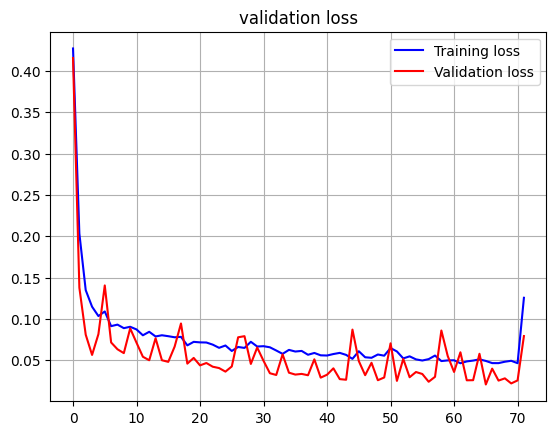

Evaluate model on test data
4/4 [==============================] - 0s 27ms/step
--------------------------------------------------------
test MAPE: 4.267097874064888 %
-------------------------------------------------------
Trend Catch Accuracy: 64.22018348623854 %


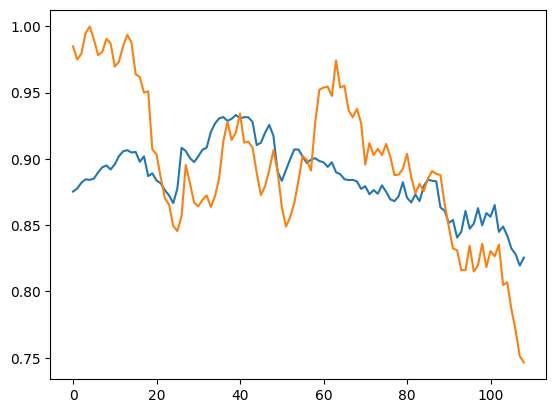

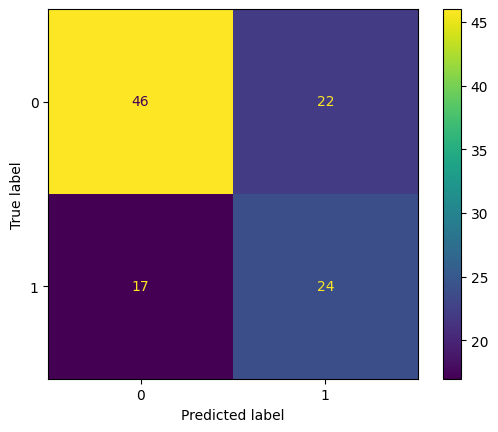

'Try me again B'

In [59]:
run_nets(5, 50)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 116, 128)          66560     
                                                                 
 lstm_10 (LSTM)              (None, 116, 64)           49408     
                                                                 
 dense_9 (Dense)             (None, 116, 64)           4160      
                                                                 
 dropout_6 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)               

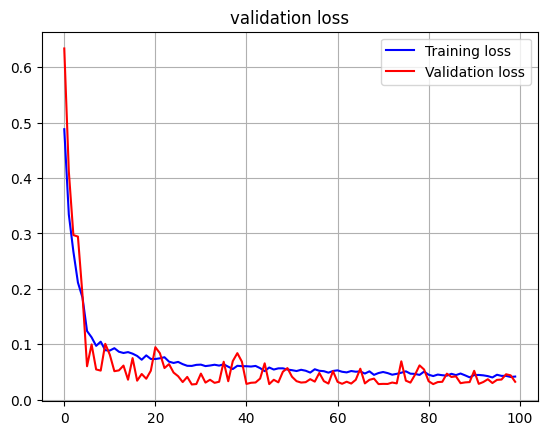

Evaluate model on test data
4/4 [==============================] - 1s 51ms/step
--------------------------------------------------------
test MAPE: 2.3272204003831733 %
-------------------------------------------------------
Trend Catch Accuracy: 80.73394495412845 %


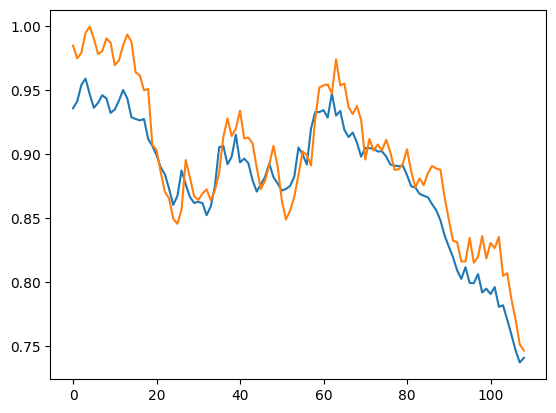

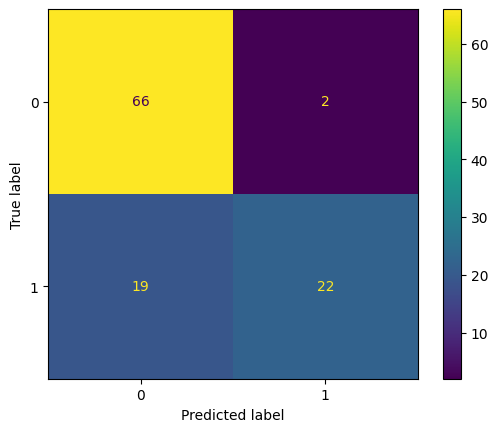

'Try me again B'

In [60]:
run_nets(5, 100)
